# Life Expectancy using Linear Regression
## Milestone 4: Unusual Observations - TODO


In [99]:
# import the necessary packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.stats.outliers_influence as sts
from patsy import dmatrices

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import itertools

## 1. Preliminary Exploratory Data Analysis

In [100]:
# Load the datafile from the previous milestone. 
# Use the column “State” for the index of the dataframe. 
# Make the columns “Region” and “Division” categorical. 
# Define a new column “Income” that is the result of dividing “Income2017” by 1000.
# Check the uploaded file

df_state = pd.read_csv("~/OneDrive/Documents/manning live projects/Life Expectancy/state_data_clean.csv", delimiter=",")
df_state.set_index("State")
df_state["Region"].astype("category")
df_state["Division"].astype("category")
df_state["Income"] = df_state["Income2017"]/1000
print(df_state)


             State  LifeExp2018  Income2017  HSGradPer  BADegPer  AdvDegPer  \
0           Alaska    78.800003       73181       92.4      29.0       10.4   
1          Arizona    79.900002       56581       82.1      28.4       10.7   
2         Arkansas    75.900002       45869       85.6      22.0        7.9   
3       California    81.599998       71805       82.5      32.6       12.2   
4         Colorado    80.500000       69117       91.1      39.4       14.6   
5      Connecticut    80.900002       74168       90.2      38.4       17.0   
6         Delaware    78.400002       62852       89.3      31.0       12.9   
7          Georgia    77.800003       56183       86.3      29.9       11.4   
8           Hawaii    82.300003       77765       91.6      32.0       10.8   
9            Idaho    79.300003       52225       90.2      26.8        8.5   
10        Illinois    79.300003       62992       88.6      33.4       13.0   
11         Indiana    77.000000       54181       88

In [101]:
# Inspect the uploaded file

print(df_state.head())
print(df_state.dtypes)
print(df_state.describe())

        State  LifeExp2018  Income2017  HSGradPer  BADegPer  AdvDegPer  \
0      Alaska    78.800003       73181       92.4      29.0       10.4   
1     Arizona    79.900002       56581       82.1      28.4       10.7   
2    Arkansas    75.900002       45869       85.6      22.0        7.9   
3  California    81.599998       71805       82.5      32.6       12.2   
4    Colorado    80.500000       69117       91.1      39.4       14.6   

   Population  MurderNMTot  MurderTOT  GunMurderTot  ...  MurderRate  \
0      737709           59       57.0          39.0  ...         7.7   
1     6817565          306      278.0         171.0  ...         4.1   
2     2977853          181      164.0         110.0  ...         5.5   
3    38993940         1861     1861.0        1275.0  ...         4.8   
4     5448819          176      176.0         115.0  ...         3.2   

   GunMurderRate  TotalKmQ  LandKmQ  WaterKmQ  Abb  Region  \
0            5.3   1723337  1477953    245384   AK    West  

In [102]:
df_state.rename(
  columns={
    "MurderTOT" : "MurderTot"
  },
  inplace=True
)

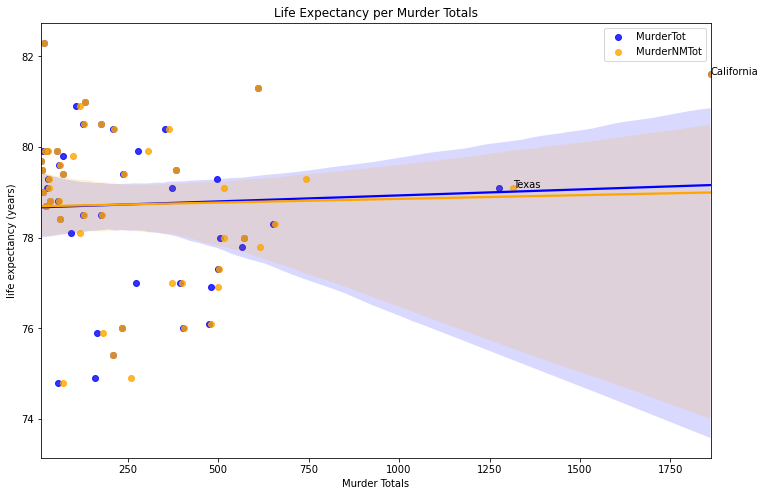

In [189]:
# Plot life expectancy against murder and non-negligent manslaughter (totals). 
# You will see that there are two states that stand apart on the x-axis. 
# These states are high-leverage points because they have an unusual combination of predictor values (in this case there is only one predictor: murder). 
# Re-run the plot annotating these states.

fig, axes=plt.subplots(1,1,figsize=(12,8))
a = sns.regplot(x = 'MurderTot', y = 'LifeExp2018', data=df_state, color="blue", label="MurderTot")
sns.regplot(x = 'MurderNMTot', y = 'LifeExp2018', data=df_state, color="orange", label="MurderNMTot")

a.set_title("Life Expectancy per Murder Totals")
a.set(xlabel="Murder Totals", ylabel="life expectancy (years)")

max_murder_states = df_state.loc[df_state['MurderNMTot'] > 1200, "State"]

for m in max_murder_states : 
    a.annotate(m, xy=((df_state.loc[df_state['State'] == m, 'MurderNMTot']),
                     (df_state.loc[df_state['State'] == m, 'LifeExp2018'])))
plt.legend()

In [104]:
# Print the states that have unusual observations
for m in max_murder_states :
    print(m)

California
Texas


35    Pennsylvania
10        Illinois
40           Texas
3       California
Name: State, dtype: object


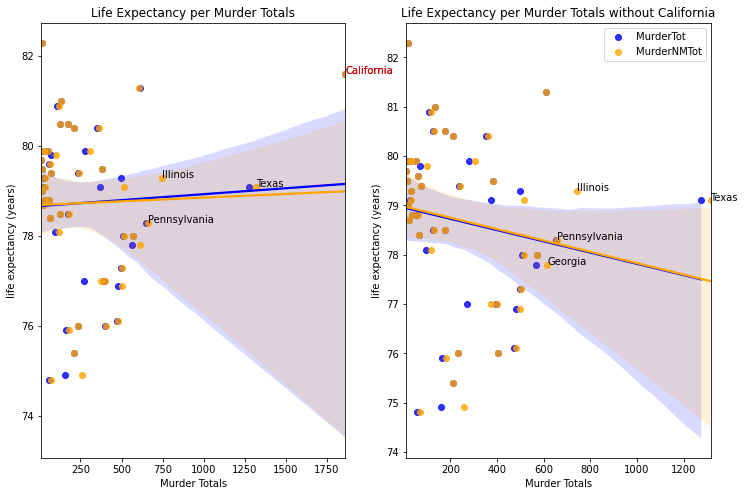

In [105]:
# Next you’ll check what happens when you eliminate "California".
# Redo the last plot and add beside (or under) it the same plot but without "California". 
# In both plots annotate the largest four observations (on the x-axis). 
# In the first plot annotate also in red the observation/s that you will not consider in the second plot ("California"). 

# Do you see changes in the regression line in the second plot?

df_state_wo_ca = df_state.drop(3, axis=0)

fig, axes=plt.subplots(1,2,figsize=(12,8))
a = sns.regplot(x = 'MurderTot', y = 'LifeExp2018', data=df_state, color="blue", label="MurderTot", 
                ax=axes[0])
sns.regplot(x = 'MurderNMTot', y = 'LifeExp2018', data=df_state, color="orange", label="MurderNMTot",
           ax=axes[0])
a.set_title("Life Expectancy per Murder Totals")
a.set(xlabel="Murder Totals", ylabel="life expectancy (years)")

b = sns.regplot(x = 'MurderTot', y = 'LifeExp2018', data=df_state_wo_ca, color="blue", label="MurderTot", 
                ax=axes[1])
sns.regplot(x = 'MurderNMTot', y = 'LifeExp2018', data=df_state_wo_ca, color="orange", label="MurderNMTot",
           ax=axes[1])
b.set_title("Life Expectancy per Murder Totals without California")
b.set(xlabel="Murder Totals", ylabel="life expectancy (years)")

df_state_sorted = df_state.sort_values(by=['MurderNMTot'])

max_murder_states = df_state_sorted.iloc[len(df_state_sorted) -4 : len(df_state_sorted), 0]
print(max_murder_states)
for m in max_murder_states : 
    a.annotate(m, xy=((df_state_sorted.loc[df_state_sorted['State'] == m, 'MurderNMTot']),
                     (df_state_sorted.loc[df_state_sorted['State'] == m, 'LifeExp2018'])))
a.annotate("California", xy=((df_state.loc[df_state['State'] == 'California', 'MurderNMTot']),
                     (df_state.loc[df_state['State'] == 'California', 'LifeExp2018'])), color='red')

df_state_sorted = df_state_wo_ca.sort_values(by=['MurderNMTot'])    
max_murder_states_no_ca = df_state_sorted.iloc[len(df_state_sorted)-4 : len(df_state_sorted), 0]
for m in max_murder_states_no_ca : 
    b.annotate(m, xy=((df_state_wo_ca.loc[df_state_wo_ca['State'] == m, 'MurderNMTot']),
                     (df_state_wo_ca.loc[df_state_wo_ca['State'] == m, 'LifeExp2018'])))
plt.legend()



In [106]:
# Now let’s inspect numerically if there are any changes. 
# Run two linear regression anaysis with and without "California"
# Here is a model for the first regression
# The analyst used the dmatrices function from the patsy API to prepare the dataframes

y, X = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df_state, return_type='dataframe')
model = sm.OLS(y, X)    # Describe model
# the method fit() returns a RegressionResults object
model_fit = model.fit()       # Fit model
# RegressionResults has a method summary that provides A LOT of information about the regression
print("With CA", model_fit.summary())
# but for the moment we only need the regression coefficients
# those are in the property params 
print("With CA", model_fit.params)

# Compare the coefficients from both regressions. 
y, X = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df_state_wo_ca, return_type='dataframe')
modelb = sm.OLS(y, X)    # Describe model
# the method fit() returns a RegressionResults object
model_fitb = modelb.fit()       # Fit model
# RegressionResults has a method summary that provides A LOT of information about the regression
print("WO CA", model_fitb.summary())
print("****", model_fitb.df_resid)
# but for the moment we only need the regression coefficients
# those are in the property params 
print("WO CA", model_fitb.params)


With CA                             OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.04781
Date:                Sat, 13 Feb 2021   Prob (F-statistic):              0.828
Time:                        17:02:46   Log-Likelihood:                -94.778
No. Observations:                  48   AIC:                             193.6
Df Residuals:                      46   BIC:                             197.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      78.6914      0.338    232.5

In [190]:
# Pack the regression plots and regression analyses in a function unusual_obs_analysis. 

def unusual_obs_analysis(rows_out, x, y, data):
    """ Prints plots and statistics of unusual observations
    
    Parameters
    ----------
    rows_out: list of rows to delete in the second plot
    x: predictor
    y: response
    data: dataframe
    
    Returns
    -------
    plot as fig, (ax0, ax1)  

    """
        
    # do the regression plots

    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols= 2,  figsize=(20, 5))   

    # first plot with all the rows in ax0
    pred = x
    resp = y
    df = data
    a = sns.regplot(x=pred , y=resp, data=df, ax=ax0)
    # annotate the largest 4 observations (on the x-axis) in the first plot
    df_sorted = df.sort_values(by=[pred])
    largest_x = df_sorted.iloc[len(df_sorted) -4 : len(df_state_sorted), 0]
    
    for m in largest_x : 
        a.annotate(m, xy=((df_sorted.loc[df_sorted.iloc[:,0] == m, pred]),
                     (df_sorted.loc[df_sorted.iloc[:,0] == m, resp])))

    # annotate in red in the first plot the observations that will be deleted in the second plot
    for r in rows_out :
        print(r)
        print(df.iloc[r,df.columns.get_loc(pred)])
        a.annotate("remove", xy=((df.iloc[r,df.columns.get_loc(pred)]),
                     (df.iloc[r,df.columns.get_loc(resp)])), color='red')     

    # second plot without the rows in *rows_out*

    # define dataframe without rows in rows_out
    df_wo = df.drop(rows_out, axis=0)

    # second plot without the rows in rows_out in ax1
    b = sns.regplot(x=pred , y=resp, data=df_wo, ax=ax1)

    fig.suptitle("Regression Plot of "+ y + " vs. "+ x)

    plt.show()

    # Do 2 regressions: with and without the rows in rows_out
    y, X = dmatrices(resp + '~' + pred , data=df, return_type='dataframe')
    model = sm.OLS(y, X)    # Describe model
    # the method fit() returns a RegressionResults object
    model_fit = model.fit()       # Fit model
    # RegressionResults has a method summary that provides A LOT of information about the regression
    #print("With rows_out included", model_fit.summary())
    # but for the moment we only need the regression coefficients
    # those are in the property params 
    print("With rows_out included", model_fit.params)
    
    y, X = dmatrices(resp + '~' + pred , data=df_wo, return_type='dataframe')
    model = sm.OLS(y, X)    # Describe model
    # the method fit() returns a RegressionResults object
    model_fitb = model.fit()       # Fit model
    # RegressionResults has a method summary that provides A LOT of information about the regression
    #print("With rows_out omitted", model_fitb.summary())
    # but for the moment we only need the regression coefficients
    # those are in the property params 
    print("With rows_out omitted", model_fitb.params)
    
    return fig, (ax0, ax1)


Now you’ll use the function to check if both "California" and "Texas" have the same impact in the coefficients of the regression.   
Run the function two times, the first time taking away "California", the second time taking away "Texas"
You will see that one of these observations has a much bigger impact in the coefficients.   

40
1316


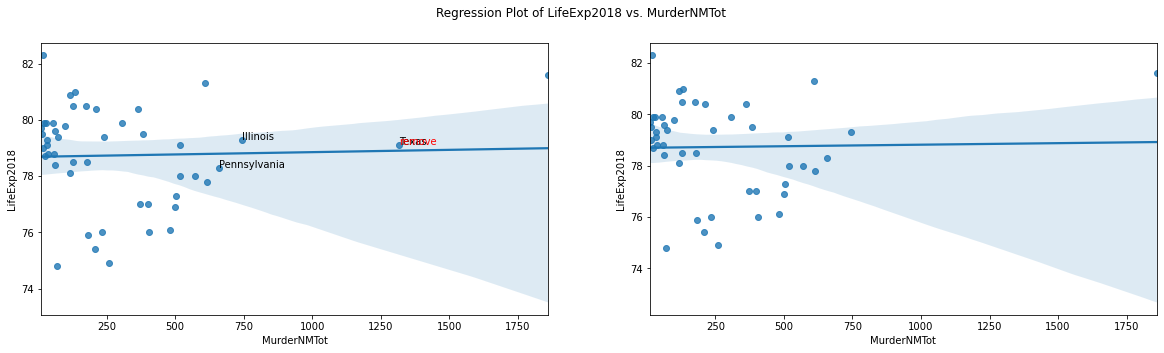

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.699264
MurderNMTot     0.000120
dtype: float64


(<Figure size 1440x360 with 2 Axes>,
 (<AxesSubplot:xlabel='MurderNMTot', ylabel='LifeExp2018'>,
  <AxesSubplot:xlabel='MurderNMTot', ylabel='LifeExp2018'>))

In [191]:
# Check the impact of removing "Texas"
unusual_obs_analysis({40}, "MurderNMTot", "LifeExp2018", df_state)

3
1861


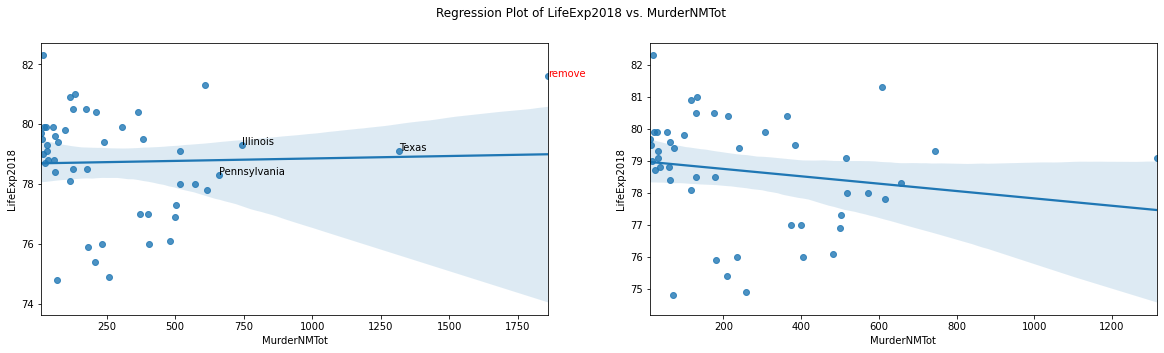

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.979680
MurderNMTot    -0.001152
dtype: float64


(<Figure size 1440x360 with 2 Axes>,
 (<AxesSubplot:xlabel='MurderNMTot', ylabel='LifeExp2018'>,
  <AxesSubplot:xlabel='MurderNMTot', ylabel='LifeExp2018'>))

In [192]:
# Check the impact of removing "California"
unusual_obs_analysis({3}, "MurderNMTot", "LifeExp2018", df_state)

## 2. High-leverage points

In the previous item of this milestone, you identified high-leverage points informally looking for observations that visually stand apart.   
Now you are going to do the same but formally, using the hat statistic. The hat value is a measure of the distance of an observation with respect to the centroid of the observations.    
You will consider observations that have 2 or 3 times the average hat value worth being examined.  


In [153]:
# Complete the hat_values_plot following the docstring.
def hat_values_plot(fit):
    """ Prints hat values plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    h_bar = p/n : mean hat value
    Observations whose hat values are >= 2 * h_bar are annotated
    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    """
   
    # number of regressors + 1
    p = fit.df_model + 1
    print("number of parameters estimated in the model", p)
    # number of observations
    n = fit.nobs
    print("number of observations", n)
    
    # mean hat value
    mean_hat = p/n
    print("mean hat", mean_hat)
    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    print("OLSInfluence object ", influence_obj)
    # get the hat values from the OLSInfluence object
    hat_values = influence_obj.summary_frame().hat_diag
    hat_values_series = pd.Series(hat_values, index = fit.resid.index, name='HatValues')
    
    fig, ax0 = plt.subplots(figsize = (15,9))
    # add a title
    ax0.set(title = "Hat Values Plot", xlabel = "State Index", ylabel = "Hat Value")
    
    # add an blue dotted horizontal line at the mean of the hat values. Label the line "mean hat"
    # add an green dashed horizontal line at 2 times the mean of the hat values. Label the line "mean hat * 2"
    # add an red dashed horizontal line at 3 times the mean of the hat values. Label the line "mean hat * 3"
    
    ax0.axhline(y=mean_hat, color='blue', label='mean hat', linestyle='--', linewidth=2)
    ax0.axhline(y=2 * mean_hat, color='g', label='mean hat * 2', linestyle='--', linewidth=2)
    ax0.axhline(y=3 * mean_hat, color='r', label='mean hat * 3', linestyle='--', linewidth=2)
    # plot the stemline with the dots
    markerline, stemlines, baseline = ax0.stem(hat_values_series.index,hat_values_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)

    # we'll rotate the ticks so that we can read them
    plt.xticks(rotation =90)
    bound = 2 * mean_hat

    # annotate and print hat values that >= bound
    largest_hats = [i for i,v in enumerate(hat_values_series > bound) if v]
    print(largest_hats)
    
    for m in largest_hats : 
        ax0.annotate(hat_values_series[m], xy= (m,hat_values_series[m]), color="green")

    ax0.legend()
    return fig, ax0


number of parameters estimated in the model 2.0
number of observations 48.0
mean hat 0.041666666666666664
OLSInfluence object  <statsmodels.stats.outliers_influence.OLSInfluence object at 0x000001D873D34EE0>
[3, 40]


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':'Hat Values Plot'}, xlabel='State Index', ylabel='Hat Value'>)

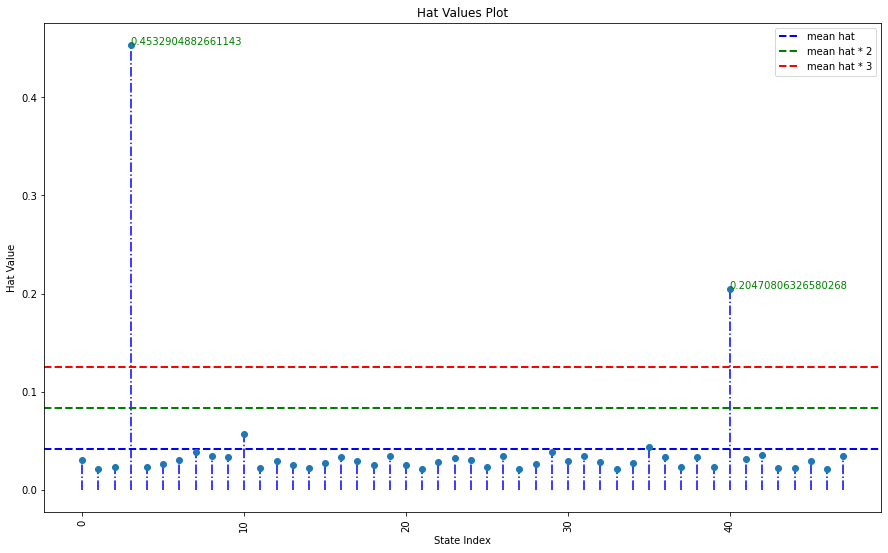

In [154]:
# Run the hat_values plot for the regression of 'LifeExp2018 ~ MurderNMTot'
hat_values_plot(model_fit)

As we have seen graphically before, Texas and California have unusual values in the predictor variable MurderNMTot.

## 3. Outliers

To detect outliers you are going to program a test that checks not the residuals, but the studentized residuals (a standarized version of the residuals).     
As a rule of thumb, you will consider an outlier any observation with a studentized residual larger than 2 or smaller than -2.   
The analyst working in the project had begun programming this function, but had left many to-dos. It is your task to finish the *check_outliers* function following to the docstring in the notebook.

Statsmodels has a class *OLSInfluence* to calculate outliers and influence measures from an *OLSResult*. 
You get an *OLSInfluence* object by applying the method *get_influence* to the *OLSResults* object that resulted from fitting the regression.    
There are two types of studentized residuals: external and internal. We are going to use the internal ones.  They are stored in the property resid_studentized-internal of the OLSResults object. 

In [155]:
def check_outliers(fit, bound = 2):
    """ Prints studentized redisuals whose absolute value exceed 2
    Parameters
    ----------
    fit: fitted model (OLSResults object)
    bound: bound to consider an observation an outlier
    
    Returns
    -------
    nothing
    """
    # recover the OLSInfluence object from the fitted model
    influence_obj = fit.get_influence()
    # get the studentized residuals (internal) from the OLSInfluence object
    student_resid = influence_obj.resid_studentized_internal
    print(student_resid)
    # print the states with studentized residuals >= bound or <= -bound
    
    i = 0
    exceeds_bound = []
    for v in student_resid :
        if np.logical_or((v >= bound),(v <= -bound)) :
         exceeds_bound.append(i)
        i = i + 1

    print(exceeds_bound)
    #TO DO - How do I get the dataframe data from the fit model?????
    print(df_state.iloc[exceeds_bound, 0])
    
    return exceeds_bound

In [156]:
# Run a regression of 'LifeExp2018 ~ MurderNMTot' and check for outliers using the function
# If you want to catch California, use a bound of 1.9
y, X = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df_state, return_type='dataframe')
model = sm.OLS(y, X)    # Describe model
# the method fit() returns a RegressionResults object
model_fit = model.fit()       # Fit model
outliers = check_outliers(model_fit, 1.9)
print (outliers)

[ 0.05643531  0.65759752 -1.60305078  1.97830934  1.01148713  1.24626098
 -0.17208967 -0.56829595  2.06057785  0.34459996  0.28156588 -0.9951976
  0.39727783 -0.12083066 -1.88882798 -1.52026172  0.00274788  0.18484868
  1.01720331 -0.4485168   1.30105364 -2.17626498 -0.83959103  0.05864043
  0.51244834 -0.12532041  0.46091949  0.9364927  -0.34753434  1.43695115
 -0.44238637  0.68868626 -1.06724695 -1.54985811  0.62218179 -0.28664105
  0.68766844 -0.99803837  0.23036735 -1.5670525   0.12184982  0.68454493
  0.57574228  0.42370624  0.95079842 -2.22537022  0.38001819  0.17488495]
[3, 8, 21, 45]
3        California
8            Hawaii
21      Mississippi
45    West Virginia
Name: State, dtype: object
[3, 8, 21, 45]


Now you will examine visually if the outliers that you have found are also influential observations.   

***************************
outlier row 3
3
1861


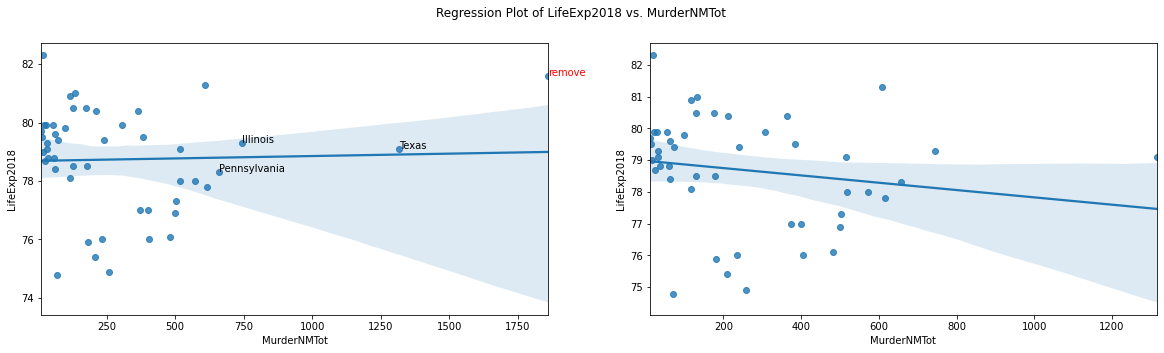

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.979680
MurderNMTot    -0.001152
dtype: float64
***************************
outlier row 8
8
19


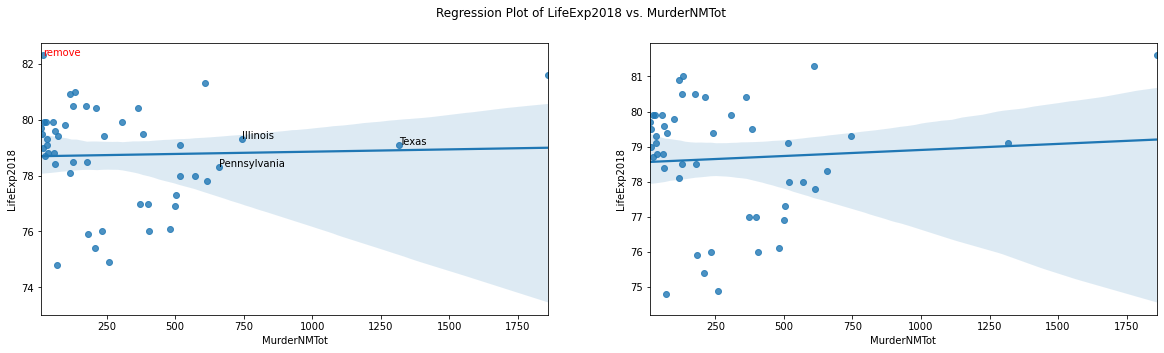

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.560218
MurderNMTot     0.000345
dtype: float64
***************************
outlier row 21
21
259


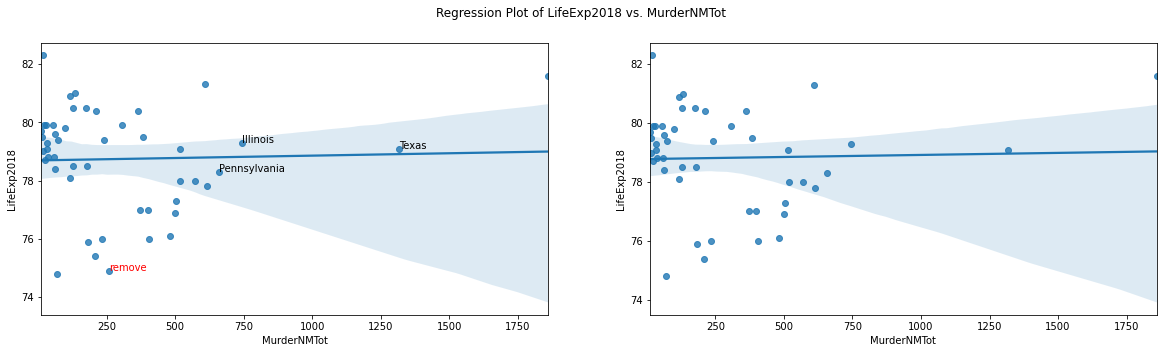

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.780262
MurderNMTot     0.000139
dtype: float64
***************************
outlier row 45
45
70


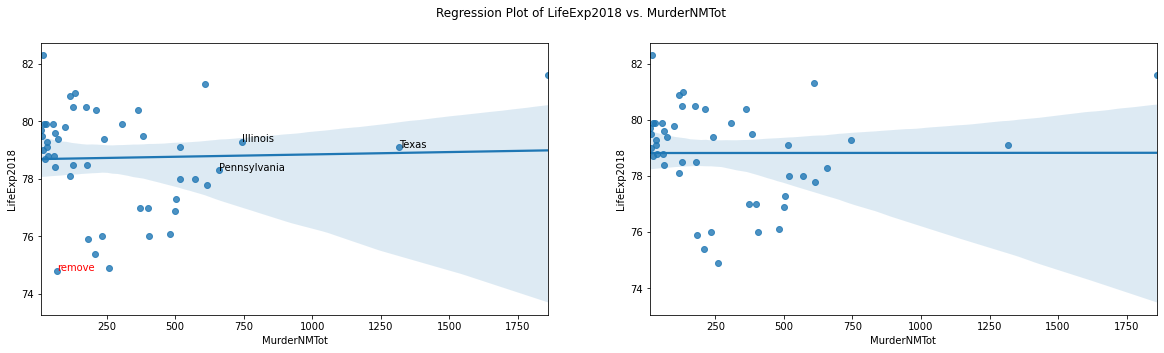

With rows_out included Intercept      78.691429
MurderNMTot     0.000163
dtype: float64
With rows_out omitted Intercept      78.822151
MurderNMTot     0.000004
dtype: float64


In [158]:
# Run the *unusual_obs_analysis* function for the outliers.
for i in outliers :
    print("***************************")
    print("outlier row", i)
    unusual_obs_analysis({i}, "MurderNMTot", "LifeExp2018", df_state)
# Pay attention to the regression coefficients and look at the regression line to see if the slope has changed when that particular observation is not considered. 

## 4. Influential Observations

In the previous items you have analyzed visually if the observations were influential.   
Now you are going to do this task formally using the Cook's distance). This measure has a direct relation with the residuals and the hat statistic.   
You will consider influential  those observations with a Cook’s distance greater than 4/(n-p-2), where p is the number of parameters in the model (including the intercept) and n is the number of observations. 

Complete the function cooks_dist_plot to plot the Cook's distance. 

In [179]:
def cooks_dist_plot(fit):
    """ Prints a Cook's distance plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    observations with a Cook's distance that exceeds 4/(n-p-2) should be annotated

    """
    # number of regressors + 1
    p = fit.df_model + 1
    print("number of parameters estimated in the model", p)
    # number of observations
    n = fit.nobs
    print("number of observations", n)
    
    bound = 4/(n-p-2)
    print("bound", bound)
    
    # get OLSInfluence Object
    influence_obj = fit.get_influence()
   
    cooks_dist = influence_obj.cooks_distance
    print("cooks dist", cooks_dist)
    cooks_dist_series = pd.Series(cooks_dist[0], index = fit.resid.index, name='CookDist')

    fig, ax0 = plt.subplots(figsize = (15,9))

    ax0.set(title = "Cook's Distance Plot", xlabel = "Observation Number", ylabel = "Cooks Distance")
   
    # add an green dashed horizontal line at bound, label the line with "4/(n-p-1)"
    ax0.axhline(y=bound, color='green', label='4/(n-p-1)', linestyle='--', linewidth=2)
    # if you want add stems to the plot

    # plot the stemline with the dots
    markerline, stemlines, baseline = ax0.stem(cooks_dist_series.index,cooks_dist_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)

    # we'll rotate the ticks so that we can read them
    plt.xticks(rotation =90)
    # TO DO
    # annotate and print values with Cook's distance >= bound
    largest_cooks = [i for i,v in enumerate(cooks_dist_series > bound) if v]
    print(largest_cooks)
    
    for m in largest_cooks : 
        ax0.annotate(cooks_dist_series[m], xy= (m,cooks_dist_series[m]), color="red")

    ax0.legend()
    return fig, ax0  

number of parameters estimated in the model 2.0
number of observations 48.0
bound 0.09090909090909091
cooks dist (array([5.03001936e-05, 4.60551033e-03, 3.03947569e-02, 1.62247639e+00,
       1.22108402e-02, 2.10531503e-02, 4.62521549e-04, 6.54012063e-03,
       7.52310274e-02, 2.02560753e-03, 2.37049643e-03, 1.10962028e-02,
       2.40453821e-03, 1.92766821e-04, 4.03614571e-02, 3.20130087e-02,
       1.32225710e-07, 5.18791426e-04, 1.36613473e-02, 3.57218705e-03,
       2.20916632e-02, 5.09369920e-02, 1.03072998e-02, 5.79814507e-05,
       4.11273639e-03, 1.86760041e-04, 3.82002598e-03, 9.70718983e-03,
       1.63717290e-03, 4.10641038e-02, 2.97954268e-03, 8.35431247e-03,
       1.65670216e-02, 2.63658824e-02, 5.48937129e-03, 1.89558506e-03,
       8.13711000e-03, 1.15960226e-02, 9.05246232e-04, 2.89301939e-02,
       1.91085699e-03, 7.50537739e-03, 6.03127509e-03, 2.03892633e-03,
       1.01990501e-02, 7.58625885e-02, 1.57594813e-03, 5.46712346e-04]), array([0.9999497 , 0.99540554, 0

(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':"Cook's Distance Plot"}, xlabel='Observation Number', ylabel='Cooks Distance'>)

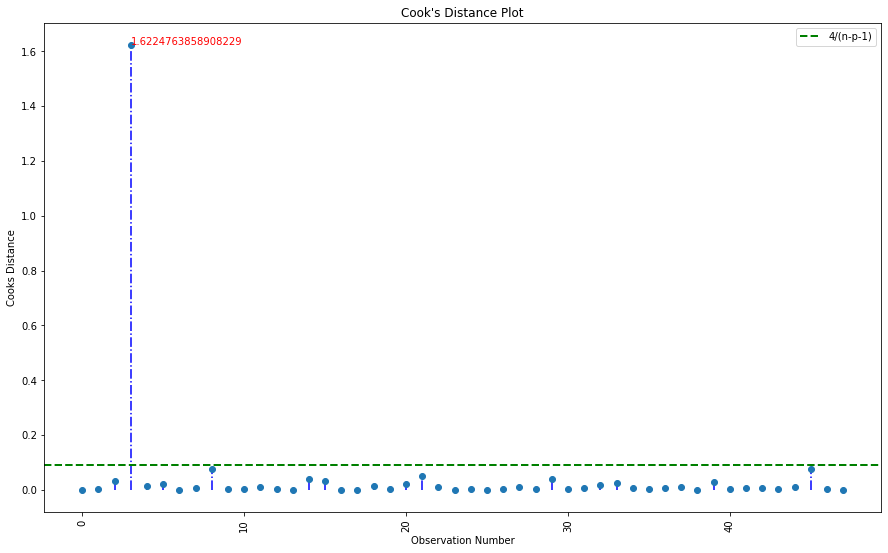

In [180]:
# run the Cook's distance plot on the regression of 'LifeExp2018 ~ MurderNMTot'
y, X = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df_state, return_type='dataframe')
model = sm.OLS(y, X)    # Describe model
# the method fit() returns a RegressionResults object
model_fit = model.fit()       # Fit model
cooks_dist_plot(model_fit)

The statsmodels library has an influence plot.  
Read the documentation and make an influence plot for 'LifeExp2018 ~ MurderNMTot’.   
Add to the plot three horizontal lines at -2, 0 and 2 and three vertical lines at the average hat value and at two and three times the average hat value.   
Do the results agree with what we have already found ?

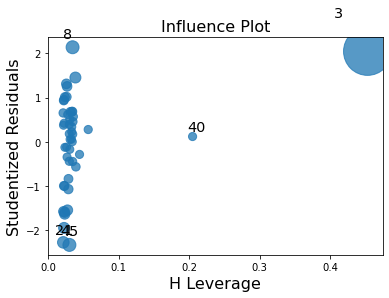

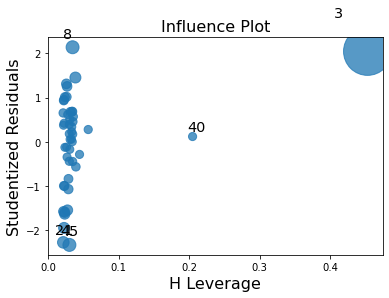

In [187]:
# Read the documentation and make an influence plot for 'LifeExp2018 ~ MurderNMTot'
# Do the results agree with what we have already found ?
y, X = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df_state, return_type='dataframe')
model = sm.OLS(y, X)    # Describe model
# the method fit() returns a RegressionResults object
model_fit = model.fit()       # Fit model

#fig, ax0 = plt.subplots(figsize = (15,9))
#ax0.set(title = "Influence Plot")
influence_plot(model_fit, external=True, alpha=0.05, criterion='cooks', size=48, plot_alpha=0.75, ax=None)